# Sensitivity Analysis

In this tutorial we demonstrate how to perform sensitivity analysis as part of the `AutoEmulate` workflow. The tutorial covers:

1. Setting up an example simulation: here we use our "FlowProblem" simulator. The system simulated is from the field of cardiovascular modeling, a tube with an input flow rate at any given time. The tube is divided to 10 compartments which allows for the study of the pressure and flow rate at various points in the tube. See "The Flow Problem" below for more details.
2. Running the simulation for 100 sets of parameters sampled from the parameter space.
3. Using Autoemulate to find the best emulator for this simulation
4. Performing sensitivity analysis.

<details>
<summary>The Flow Problem</summary>

In the field of cardiovascular modeling, capturing the dynamics of blood flow and the associated pressures and volumes within the vascular system is crucial for understanding heart function and disease. Physics-based models that accurately represent these dynamics often require significant computational resources, making them challenging to apply in large-scale or real-time scenarios. Emulation techniques provide a way to achieve high-fidelity simulations of the cardiovascular system, allowing for efficient and accurate analysis of key hemodynamic parameters.
</details>

In [1]:
from autoemulate.experimental.compare import AutoEmulate
from autoemulate.experimental.sensitivity_analysis import SensitivityAnalysis
from autoemulate.experimental.simulations.flow_problem import FlowProblem
import warnings
warnings.filterwarnings("ignore")
figsize = (9, 5)

Set up the simulation parameters and ranges:

In [2]:
param_ranges = {"T": (0.5, 2.0), # Cardiac cycle period (s)
                "td": (0.1, 0.5), # Pulse duration (s)
                "amp": (100.0, 1000.0), # Amplitude (e.g., pressure or flow rate)
                "dt": (0.0001, 0.01), # Time step (s)
                "C": (20.0, 60.0), # Compliance (unit varies based on context)
                "R": (0.01, 0.1), # Resistance (unit varies based on context)
                "L": (0.001, 0.005), # Inductance (unit varies based on context)
                "R_o": (0.01, 0.05), # Outflow resistance (unit varies based on context)
                "p_o": (5.0, 15.0)} # Initial pressure (unit varies based on context)
output_names = ["pressure"]

simulator = FlowProblem(
    param_ranges=param_ranges,
    output_names=output_names,
)

Run the simulation for 100 sets of parameters sampled from the parameter space:

In [3]:
x = simulator.sample_inputs(100)
y = simulator.forward_batch(x)

Running simulations: 100%|██████████| 100/100 [00:40<00:00, 2.48sample/s] 


In [4]:
x.shape, y.shape

(torch.Size([100, 9]), torch.Size([100, 1]))

Use AutoEmulate to find the best emulator for this simulation:

In [5]:
ae = AutoEmulate(x, y, models=["MLP", "GPE"])  # remove models argument to use all models
best = ae.best_result()
best.model_name

Comparing models: 100%|██████████| 2.00/2.00 [00:28<00:00, 14.3s/model]


'GaussianProcessExact'

### Sensitivity Analysis

1. Define the problem by creating a dictionary which contains the names and the boundaries of the parameters 
2. Evaluate the contribution of each parameter via the Sobol and Morris methods.

In [6]:
problem = {
    'num_vars': simulator.in_dim,
    'names': simulator.param_names,
    'bounds': simulator.param_bounds,
    'output_names': simulator.output_names,
    }
sa = SensitivityAnalysis(best.model, problem=problem)

Sobol metrics:

- $S_1$: First-order sensitivity index.
- $S_2$: Second-order sensitivity index.
- $S_t$: Total sensitivity index.

Sobol interpretation:
- $S_1$ values sum to ≤ 1.0 (exact fraction of variance explained)
- $S_t - S_1$ = interaction effects involving that parameter
- Large $S_t - S_1$ gap indicates strong interactions


In [7]:
sobol_df = sa.run("sobol")
sobol_df

,output,parameter,index,value,confidence
0,pressure,T,S1,0.000773,0.000080
1,pressure,td,S1,0.022267,0.003006
2,pressure,amp,S1,0.934957,0.057952
3,pressure,dt,S1,0.000038,0.000007
4,pressure,C,S1,0.012715,0.001638
5,pressure,R,S1,0.043382,0.004799
6,pressure,L,S1,0.001548,0.000172
7,pressure,R_o,S1,0.000034,0.000005
8,pressure,p_o,S1,0.000131,0.000027
0,pressure,T,ST,0.000309,0.002412


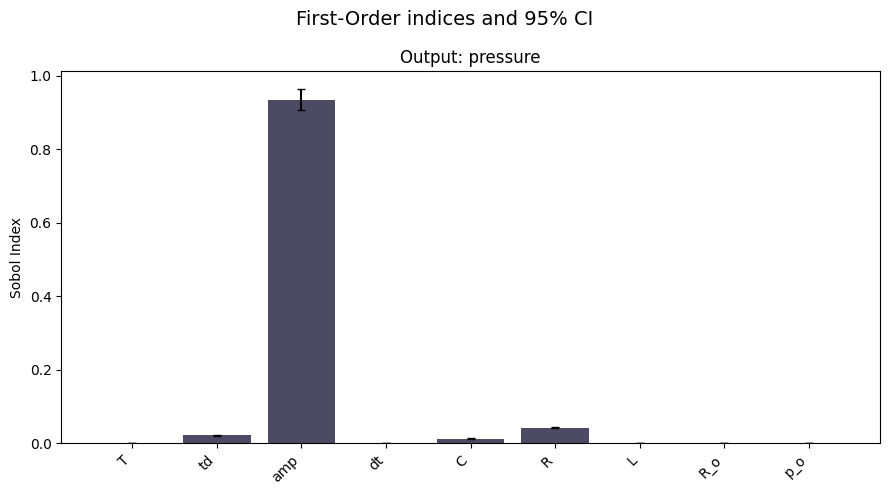

In [8]:
sa.plot_sobol(sobol_df, index="S1", figsize=figsize) 

Morris Interpretation:

- High $\mu^*$, Low $\sigma$: Important parameter with linear/monotonic effects
- High $\mu^*$, High $\sigma$: Important parameter with non-linear effects or interactions
- Low $\mu^*$, High $\sigma$: Parameter involved in interactions but not individually important
- Low $\mu^*$, Low $\sigma$: Unimportant parameter

In [11]:
morris_df = sa.run("morris")
morris_df

,output,parameter,mu,mu_star,sigma,mu_star_conf
0,pressure,T,-19.202166,20.112795,13.853851,0.736538
1,pressure,td,108.656898,109.432869,88.816246,5.696126
2,pressure,amp,703.764343,703.764343,95.035027,6.426935
3,pressure,dt,-2.237849,4.273749,5.743486,0.270442
4,pressure,C,-75.399628,76.706703,63.592308,3.813688
5,pressure,R,-138.050446,138.066177,77.101234,4.273213
6,pressure,L,23.863737,24.130026,15.963814,0.957727
7,pressure,R_o,1.703449,4.156425,5.004557,0.206334
8,pressure,p_o,6.091853,7.829870,9.546893,0.472090


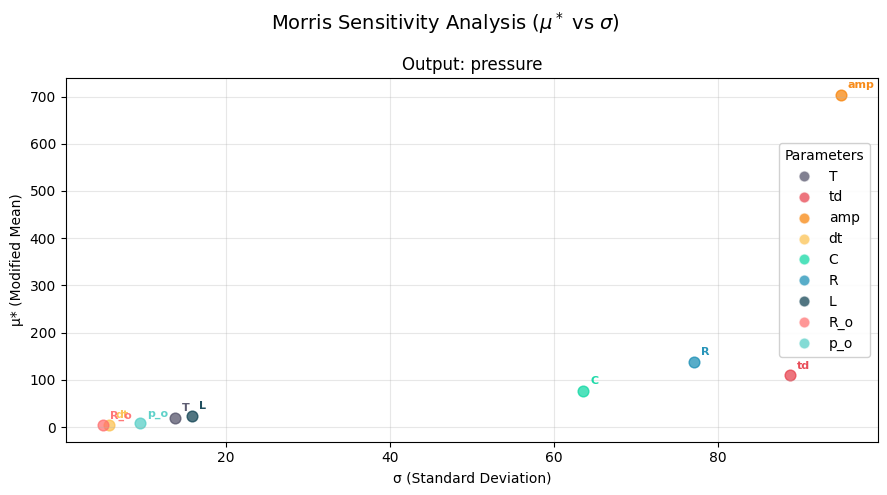

In [12]:
sa.plot_morris(morris_df, figsize=figsize)